In [9]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

### Boilerplate - Spark Session & HDFS Access

In [10]:
cwd = os.getcwd()
for part in cwd.split('/'):
    if part.lower().startswith('edureka'):
        user_id = part.title()
app_name = '{0} : Linear Regression'.format(user_id)
app_name

'Edureka_121039 : Linear Regression'

In [11]:
spark = SparkSession.builder.appName(app_name).getOrCreate()
sparkContext = spark.sparkContext
sqlContext = SQLContext(sparkContext)

In [12]:
def get_hdfs_filepath(file_name):
    my_hdfs = '/user/{0}/datasets'.format(user_id.lower())
    return os.path.join(my_hdfs, file_name)

### Dataset
[Boston Housing Price dataset details](https://www.kaggle.com/c/boston-housing "Boston Housing Price Dataset")

In [13]:
BOSTON_CSV = get_hdfs_filepath('boston.csv')

### Linear Regression

In [14]:
# house_df = sqlContext.read.format('csv').options(header='true', inferschema='true').load(BOSTON_CSV)
house_df = spark.read.csv(BOSTON_CSV,inferSchema=True,header=True)
print(house_df.take(1))
print(house_df.count(), len(house_df.columns))

[Row(CRIM=0.00632, ZN=18.0, INDUS=2.309999943, CHAS=0, NOX=0.537999988, RM=6.574999809, AGE=65.19999695, DIS=4.090000153, RAD=1, TAX=296, PT=15.30000019, B=396.8999939, LSTAT=4.980000019, MV=24.0)]
(506, 14)


In [15]:
house_df.cache()
house_df.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PT: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MV: double (nullable = true)



In [16]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CRIM,506,3.6135235608162057,8.601545086715594,0.00632,88.97619629
ZN,506,11.363636363636363,23.32245299451514,0.0,100.0
INDUS,506,11.136778749531626,6.86035298095724,0.460000008,27.73999977
CHAS,506,0.0691699604743083,0.2539940413404101,0,1
NOX,506,0.5546950602312246,0.1158776754570543,0.38499999,0.870999992
RM,506,6.28463438896641,0.7026171549511354,3.561000109,8.779999733
AGE,506,68.57490120115612,28.148861532793276,2.900000095,100.0
DIS,506,3.7950426960059325,2.105710142043288,1.129600048,12.12650013
RAD,506,9.549407114624506,8.707259384239366,1,24


In [17]:
import pandas as pd
from pylab import *

In [18]:
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

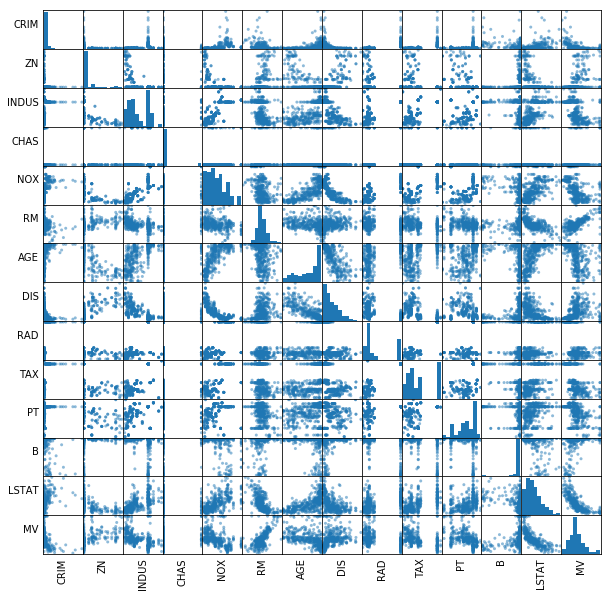

In [19]:
# call to render visuals
show()

In [20]:
print(house_df.select('CRIM').take(1)) # List of rows

[Row(CRIM=0.00632)]


In [21]:
print(house_df.select('CRIM').take(1)[0][0]) # individual row

0.00632


In [22]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('MV',i))

('Correlation to MV for ', 'CRIM', -0.3883046116575088)
('Correlation to MV for ', 'ZN', 0.36044534463752903)
('Correlation to MV for ', 'INDUS', -0.48372517128143383)
('Correlation to MV for ', 'CHAS', 0.17526017775291847)
('Correlation to MV for ', 'NOX', -0.4273207763683772)
('Correlation to MV for ', 'RM', 0.695359937127267)
('Correlation to MV for ', 'AGE', -0.37695456714288667)
('Correlation to MV for ', 'DIS', 0.24992873873512172)
('Correlation to MV for ', 'RAD', -0.3816262315669168)
('Correlation to MV for ', 'TAX', -0.46853593528654536)
('Correlation to MV for ', 'PT', -0.5077867038116085)
('Correlation to MV for ', 'B', 0.3334608226834164)
('Correlation to MV for ', 'LSTAT', -0.7376627294671615)
('Correlation to MV for ', 'MV', 1.0)


In [23]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PT', 'B', 'LSTAT'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'MV'])
vhouse_df.show(3)

+--------------------+-----------+
|            features|         MV|
+--------------------+-----------+
|[0.00632,18.0,2.3...|       24.0|
|[0.027310001,0.0,...|21.60000038|
|[0.02729,0.0,7.07...|34.70000076|
+--------------------+-----------+
only showing top 3 rows



In [24]:
# Validation Set - set aside training data for validation
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [25]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='MV', maxIter=10, regParam=0.2, elasticNetParam=0.9)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.04205955521894269,0.00616930523887228,-0.03418322912569105,2.847265401077682,-6.4175707236287,4.708495724368902,0.0,-0.5755726866889729,0.0,0.0,-0.8384020250859582,0.009552230230996729,-0.46748807612398935]
Intercept: 17.0646605349


In [26]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.693456
r2: 0.737701


In [27]:
train_df.describe().show()

+-------+------------------+
|summary|                MV|
+-------+------------------+
|  count|               351|
|   mean|23.006267847823366|
| stddev| 9.177286634617301|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [28]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","MV","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MV",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
|30.883730444318484|       24.0|[0.00632,18.0,2.3...|
| 28.10368350090055|       22.0|[0.01096,55.0,2.2...|
| 38.96637158881218|       50.0|[0.01381,80.0,0.4...|
|27.816774876903388|       24.5|[0.01501,80.0,2.0...|
|26.229099739328678|23.10000038|[0.0187,85.0,4.15...|
+------------------+-----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.661579


In [29]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5.32385


In [30]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5, 0.42903617561819535, 0.21738674591998672, 0.19351565080539945, 0.16291937799695166, 0.16091669297606265, 0.16037301516118588, 0.15946740291807213, 0.1589522459216911, 0.15878360771892808, 0.15847155228997936]
+--------------------+
|           residuals|
+--------------------+
|  0.8079779949324681|
|0.056184699558677664|
|   4.756278110631449|
|  1.4483730146146208|
|0.053553199663433304|
| -1.6473402603843255|
|   7.331542087526913|
|   8.681289008834682|
|  3.1660779343812635|
|   1.358739357582298|
|   6.006254870169556|
| -1.5874023978975593|
|   5.238794695280667|
|-0.42525950327679496|
|  -4.175273800075189|
|   2.971519856324278|
|  -1.502615063995897|
| 0.01998212605207783|
|  2.2129791136644563|
| -1.5045835821493725|
+--------------------+
only showing top 20 rows



In [31]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","MV","features").show()

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
|30.883730444318484|       24.0|[0.00632,18.0,2.3...|
| 28.10368350090055|       22.0|[0.01096,55.0,2.2...|
| 38.96637158881218|       50.0|[0.01381,80.0,0.4...|
|27.816774876903388|       24.5|[0.01501,80.0,2.0...|
|26.229099739328678|23.10000038|[0.0187,85.0,4.15...|
| 21.08838795562452|20.10000038|[0.019649999,80.0...|
| 39.82996092247758|       50.0|[0.020090001,95.0...|
|27.211831315986647|       16.5|[0.024979999,0.0,...|
|25.781203131844897|21.60000038|[0.027310001,0.0,...|
| 29.03928199163645|30.79999924|[0.027629999,75.0...|
| 32.15280431595257|34.90000153|[0.03359,75.0,2.9...|
|20.478217581260502|       19.5|[0.03427,0.0,5.19...|
|24.467326595147078|19.39999962|[0.03466,35.0,6.0...|
|22.977558594809718|20.89999962|[0.03548,80.0,3.6...|
|24.537190141216804|22.89999962|[0.03551,25.0,4.8...|
|28.808183979843786|       2

In [8]:
spark.stop()